*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Prédiction de la consommation d'énergie des bâtiments publiques à Seattle</div>

*******

### Tables des matières<a class="anchor" id="retour"></a>

[Présentation de la partie 2](#Présentation)


* [Partie 3 🛠 Machine Learning (Régression) ](#Partie_3)

    * [3.1 Régression lineaire comme baseline](#Section_3.1)
        * [3.1.a)  Baseline sur données brut](#Section_3.1.a)
        * [3.1.b)  Baseline sur données préparées](#Section_3.1.b)
    * [3.2 Régression linéaire sur données centrées réduite](#Section_3.2)
    * [3.3 Régression Ridge ](#Section_3.3)
    * [3.4 Régression LASSO ](#Section_2.4)
    * [3.5 Régression sur les 3 premières composantes principales ](#Section_2.5)
    * [3.6 Régression linéaire sur données en log ](#Section_2.6)
    * [3.7 Gradient Boosting regressor sur données en log (Scikit Learn) ](#Section_2.7)
    * [3.8 XGBoost](#Section_2.8)
    * [3.9 XGBoost (avec ENERGYSTARScore)](#Section_2.9)


[Conclusion partie 2](#Conclusion)

[Références](#Références)

****
<div style="padding:20px;color:black;margin:0;font-size:200%;display:fill;border-radius:5px;background-color:#e9f1fc;overflow:hidden;font-weight:500">Partie 2 🛠 Machine Learning (Régression)</div>
<a class="anchor" id="Partie_2"></a>

****

In [426]:
# Importation des librairies

import pandas as pd
import numpy as np

# Lib pour réaliser des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Lib pour mesurer le temps execution
import time


# Lib pour regression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

# Lib pour séparer les données en 2 sets
from sklearn.model_selection import train_test_split

# Lib pour travailler sur les données CR
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.decomposition

# Lib pour remplacer les données manquantes
from sklearn.impute import KNNImputer

# Lib pour réccupérer le RMSE
from sklearn.metrics import mean_squared_error

# Lib pour le passage en log
import math

# Lib pour le gridsearch et les métriques
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

## Présentation partie 3
<a class="anchor" id="Partie_2"></a>

Cette étude a pour objectif de présenter les différentes méthodes de régression linéaire des librairies
Scikit learn et la très populaire XGBoost.
Il s'agit d'expliquer la variable "TotalGHGEmissions"


In [427]:
# Importation des données
df = pd.read_csv("df.csv",sep=";")
df_float = pd.read_csv("df_float.csv",sep=";")
df_objet = pd.read_csv("df_objet.csv",sep=";")

In [428]:
# Suppression des colonnes inutiles
df_float = df_float.drop(columns=["Unnamed: 0"])
df_objet = df_objet.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [429]:
target = df[["TotalGHGEmissions"]]

### Création de fonctions

In [430]:
# Création d'une fonction qui renvoit le RMSE

def rmse(X_test,pred):
    MSE = mean_squared_error(y_test, pred.prediction)
    RMSE = math.sqrt(MSE)
    return print(RMSE)

In [431]:
# Création d'une fonction qui passe un df au log

def df_au_log(data_1):
    val = np.log(data_1.values)
    data_2 = pd.DataFrame(data=val,columns=data_1.columns,index=data_1.index)
    return data_2

In [432]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue

def coef_sort(model):
    coef = pd.DataFrame(data=model.coef_,columns=df_float.columns)
    coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
    coef["coeff_sort"] = coef["coeff"].abs()
    coef = coef.sort_values(by="coeff_sort",ascending=False)
    return coef

## 2.1) Régression linéaire comme baseline
<a class="anchor" id="Section_2.1"></a>

Ce premier point nous permet deux choses:
- d'avoir un modèle de référence , le modèle sur données brut
- de montrer l'importance de bien comprendre et préparer les données

## 2.1.a) Baseline sur données brut
<a class="anchor" id="Section_2.1.a"></a>

In [433]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.009970903396606445 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [434]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.4757499897604227 
 R2 sur le set de test:  0.13710890471120007


In [435]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

482.02897296102776


In [436]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,14.84,92841,13.624709,1.215291
1,9.09,24000,150.516877,-141.426877
2,68.19,77662,47.503198,20.686802
3,4.92,24552,36.358505,-31.438505
4,2.28,20088,13.461291,-11.181291
...,...,...,...,...
1006,6.69,21060,118.411188,-111.721188
1007,70.31,29520,-47.306693,117.616693
1008,4.39,20598,-7.488680,11.878680
1009,15.25,44510,40.798426,-25.548426


Text(0.5, 1.0, 'Prédiction de 97% des points')

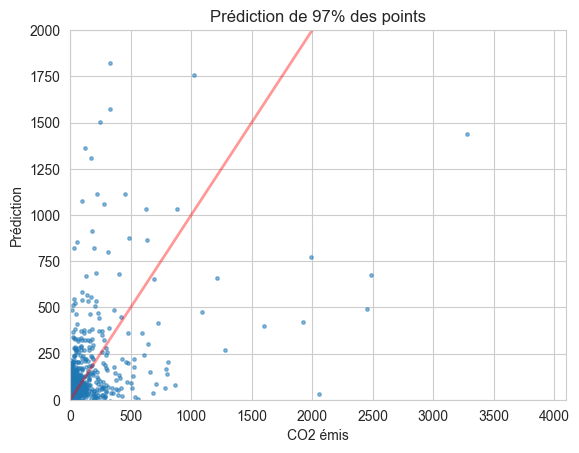

In [437]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0,2_000 ], [0.0,2_000 ], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 4_100)
plt.ylim(0, 2_000)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [438]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
NumberofBuildings,50.517269,50.517269
NumberofFloors,-14.829240,14.829240
BulType,-13.102265,13.102265
Council,-4.107425,4.107425
PPT,-2.425204,2.425204
Voisin,-1.140998,1.140998
years,0.689275,0.689275
Zip,-0.378868,0.378868
ThirdLargestPropertyUseTypeGFA,0.011729,0.011729
SecondLargestPropertyUseTypeGFA,0.002980,0.002980


Text(0.5, 1.0, 'Coefficients de regression')

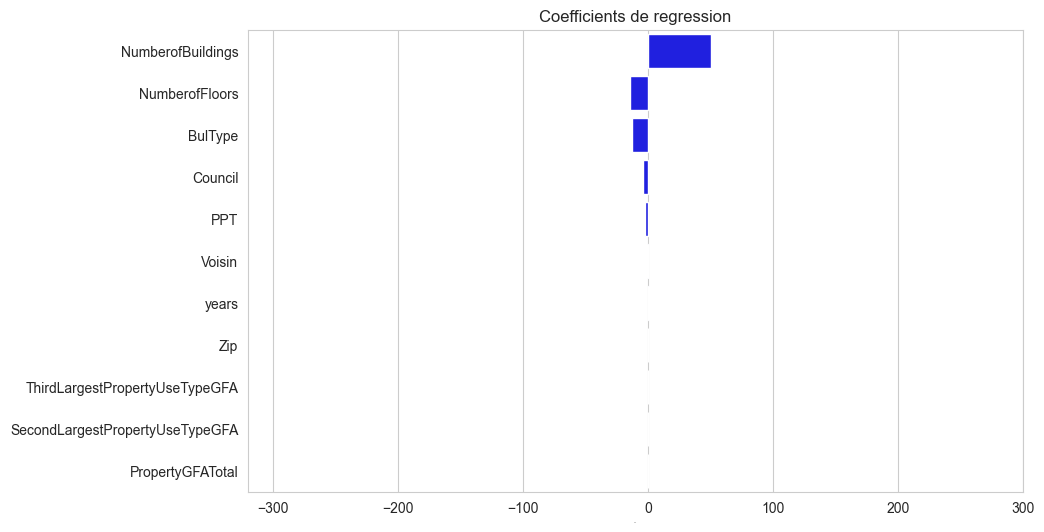

In [439]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320, 300)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Préparation des données

In [440]:
df_float=df_float.drop(columns=["NumberofBuildings"])

In [441]:
# Création de la variable tx_gaz
df_float["tx_gaz"]=df["NaturalGas(kBtu)"]/df["SiteEnergyUse(kBtu)"]
df_float["tx_gaz"] = df_float["tx_gaz"].replace(np.inf, 1)
df_float["tx_gaz"] = df_float["tx_gaz"].fillna(0)

In [442]:
# Suppression des lignes pour lesquelles il n'y a pas de consommation d'énergie

df_float=pd.concat([df_float,df["SiteEnergyUse(kBtu)"]],axis=1)
df_float=df_float[df_float["SiteEnergyUse(kBtu)"]>1]
df=df[df["SiteEnergyUse(kBtu)"]>1]
df_float=df_float.drop(columns=["SiteEnergyUse(kBtu)"])

In [443]:
target=df[["TotalGHGEmissions"]]

In [444]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

df_prep = pd.concat([target,df_float],axis=1)
df_prep = df_prep[df_prep["TotalGHGEmissions"]<1800]


df_float = df_prep.drop(columns=["TotalGHGEmissions"])
target = df_prep[["TotalGHGEmissions"]]

## 2.1.a) Baseline sur données préparées
<a class="anchor" id="Section_2.1.a"></a>

In [445]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.029986143112182617 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [446]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.37744508421220624 
 R2 sur le set de test:  0.38063073492214616


In [447]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

123.37891062201234


In [448]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,94.63,33997,17.899431,76.730569
1,15.58,22810,15.082956,0.497044
2,218.20,160561,195.401187,22.798813
3,7.86,30315,-3.789418,11.649418
4,28.70,163699,56.615606,-27.915606
...,...,...,...,...
994,7.21,23664,-21.257621,28.467621
995,9.70,42720,9.757799,-0.057799
996,24.63,43578,91.228917,-66.598917
997,13.27,41262,7.916184,5.353816


Text(0.5, 1.0, 'Prédiction de 97% des points')

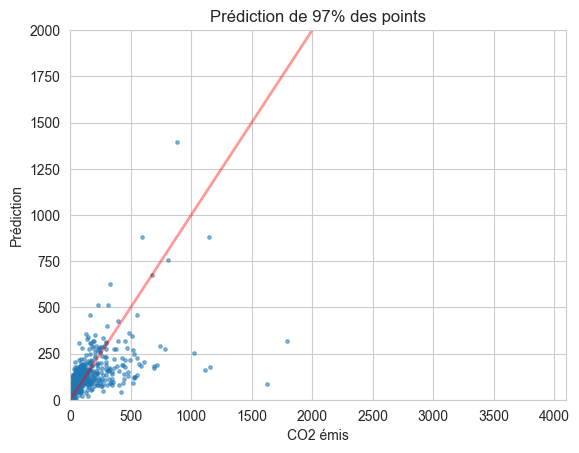

In [449]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0,2_000 ], [0.0,2_000 ], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 2_000)
plt.ylim(0, 1_500)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [450]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
tx_gaz,159.766441,159.766441
BulType,8.543085,8.543085
Council,3.064335,3.064335
Zip,-0.863652,0.863652
PPT,-0.775790,0.775790
NumberofFloors,0.168378,0.168378
Voisin,0.027177,0.027177
years,0.020188,0.020188
ThirdLargestPropertyUseTypeGFA,-0.000827,0.000827
PropertyGFATotal,0.000756,0.000756


Text(0.5, 1.0, 'Coefficients de regression')

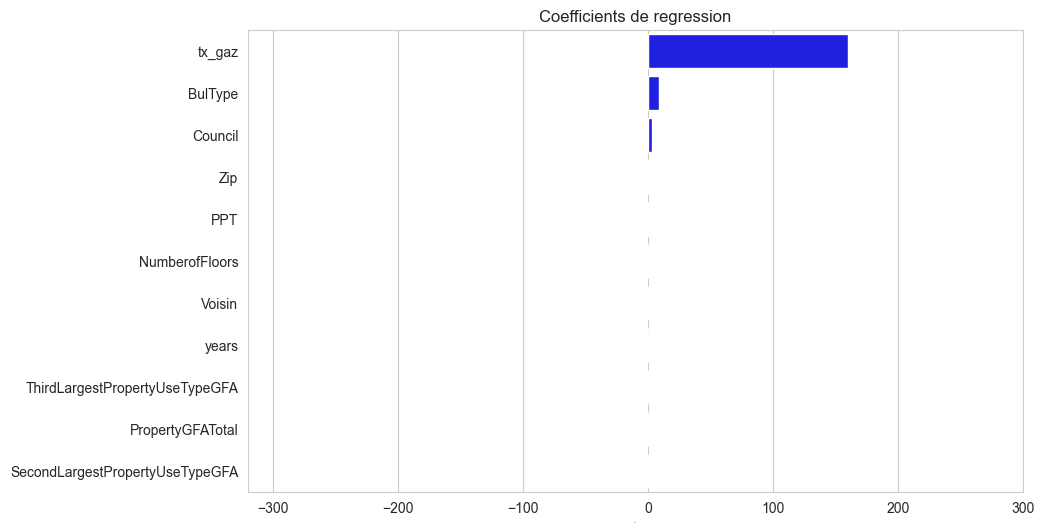

In [451]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320, 300)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.2) Régression linéaire sur données centrées réduites
<a class="anchor" id="Section_2.2"></a>

Le modèle n'a pas l'air capable de prédire les 10 plus grandes valeur de la target.
Nous ne les conservons pas pour vérifier si le modèle est plus performant.
De plus nous travaillons dans cette partie sur les données centrées réduites

In [452]:
# Données centrées réduite sur toute la table entière

std_scale = preprocessing.StandardScaler().fit(df_float)
df_float_cr = std_scale.transform(df_float)

std_scale = preprocessing.StandardScaler().fit(target)
target_cr =  std_scale.transform(target)

# Permet d'avoir en output du modèle un DF
target_cr = pd.DataFrame(data=target_cr,columns=["TotalGHGEmissions"],index=target.index)
df_float_cr = pd.DataFrame(data=df_float_cr,columns=df_float.columns,index=df_float.index)

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_cr = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print("Temps de calcul : ",temps_cr,"ms")

Temps de calcul :  0.005009174346923828 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [453]:
print("R2 sur le set d'apprentissage: ",model_cr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_cr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.37744508421220613 
 R2 sur le set de test:  0.3806307349221473


In [454]:
# Création d'un DF des valeurs prédites de X_test
pred = model_cr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.7520834563965049


In [455]:
# Création d'un DF composée de la target la prédiction et les résidus

y_cr = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_cr = pd.DataFrame(y_cr).reset_index()
y_cr = y_cr.drop(columns=["index"])
pred = pd.concat([y_cr[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred


,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,0.034409,-0.397562,-0.433319,0.467728
1,-0.447458,-0.479268,-0.450488,0.003030
2,0.787657,0.526814,0.648682,0.138975
3,-0.494517,-0.424454,-0.565528,0.071012
4,-0.367482,0.549733,-0.197316,-0.170166
...,...,...,...,...
994,-0.498479,-0.473031,-0.672010,0.173531
995,-0.483301,-0.333853,-0.482948,-0.000352
996,-0.392292,-0.327586,0.013677,-0.405968
997,-0.461539,-0.344501,-0.494174,0.032635


Text(0.5, 1.0, 'Prédiction de 92% des points')

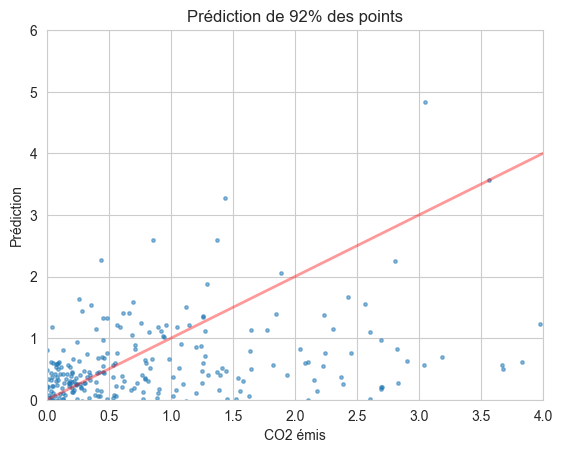

In [456]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 4)
plt.ylim(0, 6)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 92% des points')

In [457]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_cr)
coef

,coeff,coeff_sort
PropertyGFATotal,0.631320,0.631320
tx_gaz,0.263032,0.263032
SecondLargestPropertyUseTypeGFA,-0.077018,0.077018
BulType,0.061331,0.061331
Zip,-0.052979,0.052979
ThirdLargestPropertyUseTypeGFA,-0.052934,0.052934
Council,0.039639,0.039639
PPT,-0.027520,0.027520
NumberofFloors,0.005575,0.005575
years,0.004080,0.004080


Text(0.5, 1.0, 'Coefficients de regression')

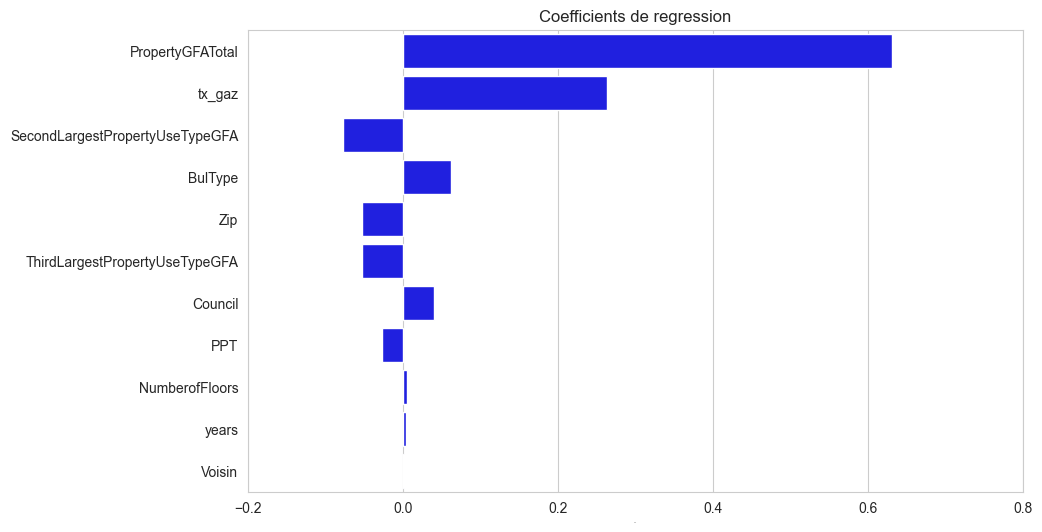

In [458]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.3) Régression Ridge
<a class="anchor" id="Section_2.3"></a>

Regression Ridge sur les données centrées réduites.
Utilisation d'un gridsearch afin de tester plusieurs hyperparamètre

In [459]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr, test_size=0.3, random_state=0)

In [460]:
# Modèle RIDGE

tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_ridge = GridSearchCV( Ridge(),
                            param_grid,
                            cv=10,
                            scoring=score )

model_ridge.fit(X_train,y_train)

tps2 = time.time()
temps_ridge = tps2 - tps1
print("Temps de calcul : ",temps_ridge,"s")

Temps de calcul :  3.502345085144043 s


In [461]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_ridge.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 100}


In [462]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_ridge.cv_results_['mean_test_score'], # score moyen
        model_ridge.cv_results_['std_test_score'],  # écart-type du score
        model_ridge.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                    mean,
                                                    std*2,
                                                    params ) )

Résultats de la validation croisée :
mean_test_score = 0.332 (+/-0.184) for {'alpha': 0.2}
mean_test_score = 0.332 (+/-0.184) for {'alpha': 0.4}
mean_test_score = 0.332 (+/-0.184) for {'alpha': 0.6}
mean_test_score = 0.332 (+/-0.184) for {'alpha': 0.8}
mean_test_score = 0.332 (+/-0.184) for {'alpha': 0.9}
mean_test_score = 0.333 (+/-0.183) for {'alpha': 2}
mean_test_score = 0.333 (+/-0.182) for {'alpha': 5}
mean_test_score = 0.333 (+/-0.181) for {'alpha': 9}
mean_test_score = 0.333 (+/-0.181) for {'alpha': 10}
mean_test_score = 0.333 (+/-0.181) for {'alpha': 11}
mean_test_score = 0.333 (+/-0.181) for {'alpha': 12}
mean_test_score = 0.334 (+/-0.171) for {'alpha': 50}
mean_test_score = 0.335 (+/-0.161) for {'alpha': 100}


In [463]:
model_ridge.best_estimator_

Ridge(alpha=100)

In [464]:
reg_ridge= Ridge(alpha=0.2)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.2)

In [465]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(reg_ridge)
coef

,coeff,coeff_sort
PropertyGFATotal,0.631137,0.631137
tx_gaz,0.263011,0.263011
SecondLargestPropertyUseTypeGFA,-0.076921,0.076921
BulType,0.061342,0.061342
Zip,-0.052973,0.052973
ThirdLargestPropertyUseTypeGFA,-0.052907,0.052907
Council,0.039633,0.039633
PPT,-0.027519,0.027519
NumberofFloors,0.005636,0.005636
years,0.004076,0.004076


Text(0.5, 1.0, 'Coefficients de regression')

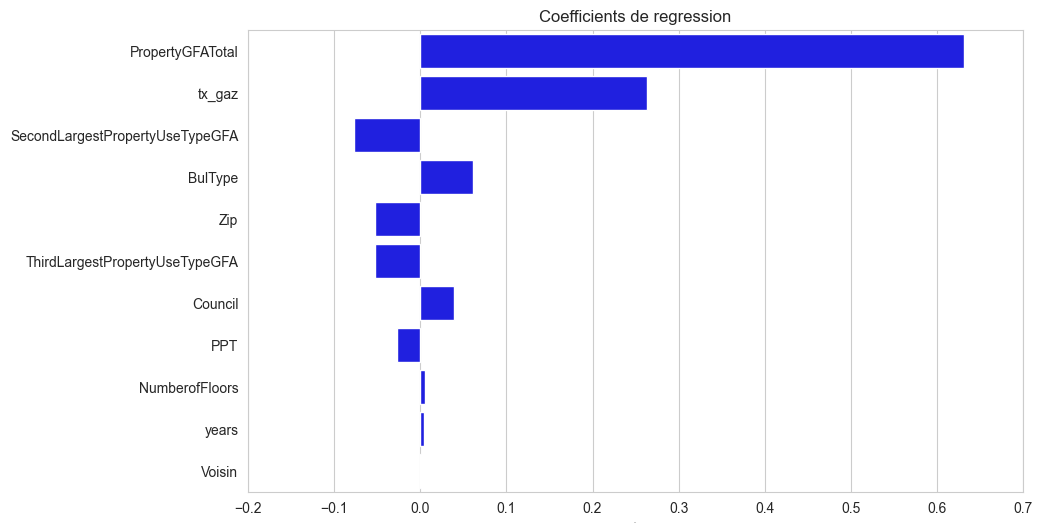

In [466]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2,0.7)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [467]:
print("R2 sur le set d'apprentissage: ",model_ridge.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_ridge.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.3755223041641227 
 R2 sur le set de test:  0.38334636830077795


In [468]:
# Création d'un DF des valeurs prédites de X_test
pred = model_ridge.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.7504328848484811


In [469]:
# Création d'un DF composée de la target la prédiction et les résidus

y_ridge = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_ridge = pd.DataFrame(y_ridge).reset_index()
y_ridge=y_ridge.drop(columns=["index"])
pred = pd.concat([y_ridge[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,0.034409,-0.397562,-0.379715,0.414124
1,-0.447458,-0.479268,-0.429073,-0.018384
2,0.787657,0.526814,0.569370,0.218287
3,-0.494517,-0.424454,-0.535757,0.041240
4,-0.367482,0.549733,-0.150144,-0.217338
...,...,...,...,...
994,-0.498479,-0.473031,-0.645711,0.147232
995,-0.483301,-0.333853,-0.469607,-0.013694
996,-0.392292,-0.327586,0.017897,-0.410189
997,-0.461539,-0.344501,-0.478439,0.016900


Text(0.5, 1.0, 'Prédiction de 97% des points')

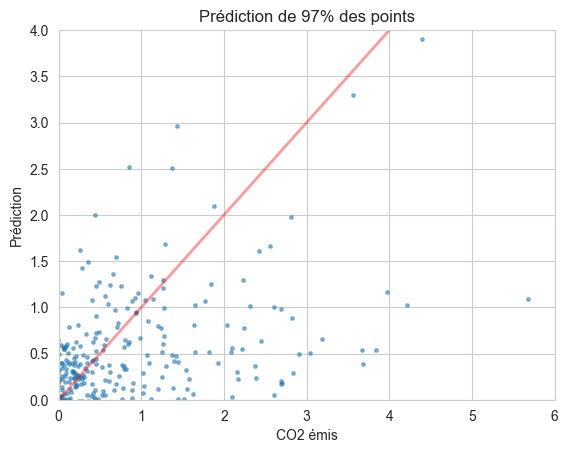

In [470]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 6)
plt.ylim(0, 4)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

La régression Ridge n'a pas amélioré le pouvoir prédictif du modèle

## 2.4) Régression LASSO
<a class="anchor" id="Section_2.4"></a>

In [471]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

In [472]:
# Modèle LASSO
tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.1,0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_lasso = GridSearchCV( Lasso(),
                      param_grid,
                      cv=10,
                      scoring=score)

model_lasso.fit(X_train,y_train)

tps2 = time.time()
temps_lasso = tps2 - tps1
print("Temps de calcul : ",temps_lasso,"s")

Temps de calcul :  0.923346757888794 s


In [473]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [474]:
# Afficher les performances correspondantes

result = 'mean_test_score'
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_lasso.cv_results_['mean_test_score'], # score moyen
        model_lasso.cv_results_['std_test_score'],  # écart-type du score
        model_lasso.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) pour {}".format( result,
                                                     mean,
                                                     std*2,
                                                     params) )

Résultats de la validation croisée :
mean_test_score = 0.330 (+/-0.129) pour {'alpha': 0.1}
mean_test_score = 0.276 (+/-0.094) pour {'alpha': 0.2}
mean_test_score = 0.137 (+/-0.067) pour {'alpha': 0.4}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 0.6}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 0.8}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 0.9}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 2}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 5}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 9}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 10}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 11}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 12}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 50}
mean_test_score = -0.003 (+/-0.011) pour {'alpha': 100}


In [475]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [476]:
# Création d'un DF des valeurs prédites de X_test
pred = model_lasso.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.7595737721731166


In [477]:
print("R2 sur le set d'apprentissage: ",model_lasso.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_lasso.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.34404136720491973 
 R2 sur le set de test:  0.36823218110070144


In [478]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.2)

In [479]:
# Création d'un DF composée de la target la prédiction et les résidus

y_lasso = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_lasso = pd.DataFrame(y_lasso).reset_index()
y_lasso=y_lasso.drop(columns=["index"])
pred = pd.concat([y_lasso[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,0.034409,-0.397562,-0.292694,0.327103
1,-0.447458,-0.479268,-0.245496,-0.201961
2,0.787657,0.526814,0.488141,0.299517
3,-0.494517,-0.424454,-0.353544,-0.140973
4,-0.367482,0.549733,0.097189,-0.464671
...,...,...,...,...
994,-0.498479,-0.473031,-0.376019,-0.122460
995,-0.483301,-0.333853,-0.311625,-0.171676
996,-0.392292,-0.327586,-0.173084,-0.219208
997,-0.461539,-0.344501,-0.316551,-0.144987


Text(0.5, 1.0, 'Prédiction de 97% des points')

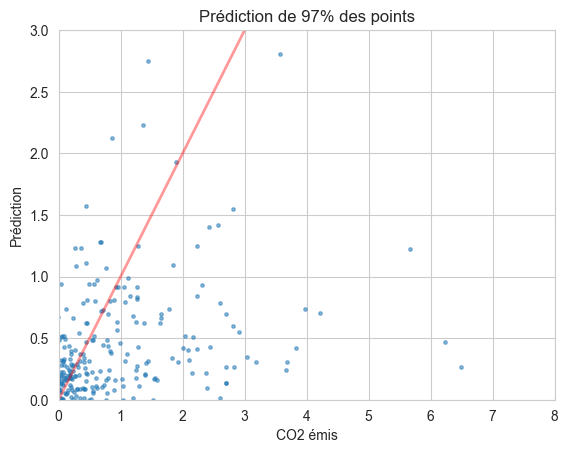

In [480]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 8)
plt.ylim(0, 3)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [481]:
# Création d'un DF composé des coefficients

coef = pd.DataFrame(data=reg_lasso.coef_, columns = ["coeff"],index=df_float_cr.columns)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.355056,0.355056
tx_gaz,0.059768,0.059768
years,0.000000,0.000000
NumberofFloors,0.000000,0.000000
SecondLargestPropertyUseTypeGFA,0.000000,0.000000
ThirdLargestPropertyUseTypeGFA,0.000000,0.000000
BulType,0.000000,0.000000
PPT,-0.000000,0.000000
Zip,-0.000000,0.000000
Council,0.000000,0.000000


Text(0.5, 1.0, 'Coefficients de regression')

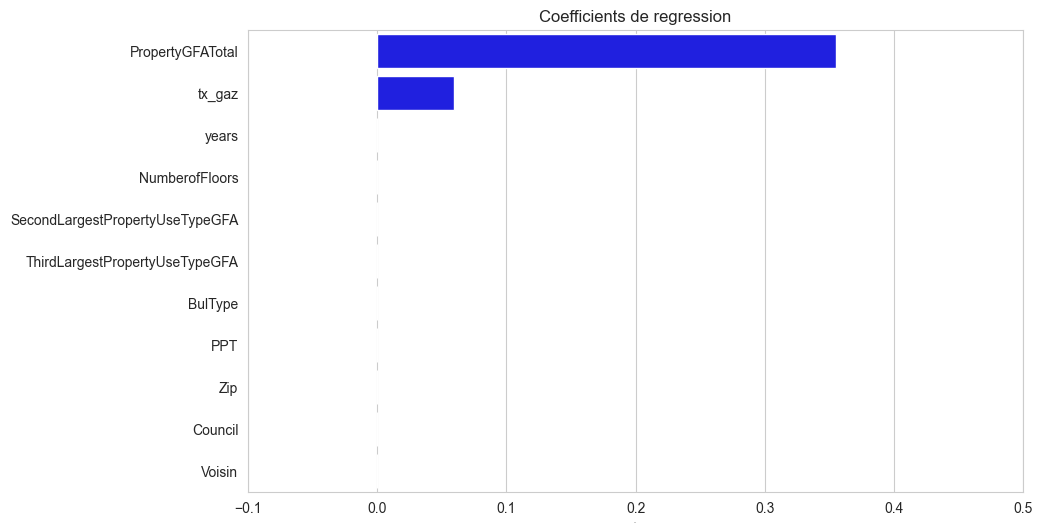

In [482]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.1, 0.5)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

La régression LASSO montre toute son utilité:
- une seule variable permet d'expliquer le modèle
- la pénalité est efficace

## 2.5) Regression sur les 3 premieres composantes principales
<a class="anchor" id="Section_2.5"></a>

In [483]:
liste_r2=[]
liste_var=[]

for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(df_float_cr)
    df_pca = pca.fit_transform(df_float_cr)

    X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

    model_pca = LinearRegression().fit(X_train, y_train)

    liste_r2.append(model_pca.score(X_test, y_test))
    liste_var.append(pca.explained_variance_ratio_.sum())

print(liste_r2,"\n",liste_var)

[0.21749137677456987, 0.2790868790576858, 0.2762191124501515, 0.32757195278062456, 0.3368913875603555, 0.34313591795534193, 0.3573119753492773, 0.3477864960873438, 0.34810489059211225, 0.3468894665000478, 0.3806307349221473] 
 [0.26102145997579096, 0.4023451893155025, 0.5288931446502327, 0.6171826001063344, 0.694987681603175, 0.7685157924811654, 0.837162424629937, 0.8934102874921858, 0.9463106147955926, 0.9821859675410706, 1.0]


In [484]:
pca = PCA(n_components=3)
pca.fit(df_float_cr)

PCA(n_components=3)

In [485]:
pca.explained_variance_ratio_.sum()

0.5288931446502328

In [486]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes
df_pca = pca.fit_transform(df_float_cr)

In [487]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_pca = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_pca = tps2 - tps1
print("Temps de calcul : ",temps_pca,"ms")

Temps de calcul :  0.0049932003021240234 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [488]:
print("R2 sur le set d'apprentissage: ",model_pca.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_pca.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.23573296889072337 
 R2 sur le set de test:  0.2762191124501516


In [489]:
# Création d'un DF des valeurs prédites de X_test
pred = model_pca.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8130079000535455


In [490]:
# Création d'un DF composée de la target la prédiction et les résidus

y_pca = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_pca = pd.DataFrame(y_pca).reset_index()
y_pca = y_pca.drop(columns=["index"])
pred = pd.concat([y_pca[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,0.034409,-0.397562,0.013287,0.021122
1,-0.447458,-0.479268,-0.216016,-0.231442
2,0.787657,0.526814,-0.287799,1.075456
3,-0.494517,-0.424454,-0.370336,-0.124181
4,-0.367482,0.549733,0.207821,-0.575302
...,...,...,...,...
994,-0.498479,-0.473031,-0.332703,-0.165776
995,-0.483301,-0.333853,-0.255072,-0.228228
996,-0.392292,-0.327586,-0.087997,-0.304295
997,-0.461539,-0.344501,-0.205698,-0.255841


Text(0.5, 1.0, 'Prédiction de 97% des points')

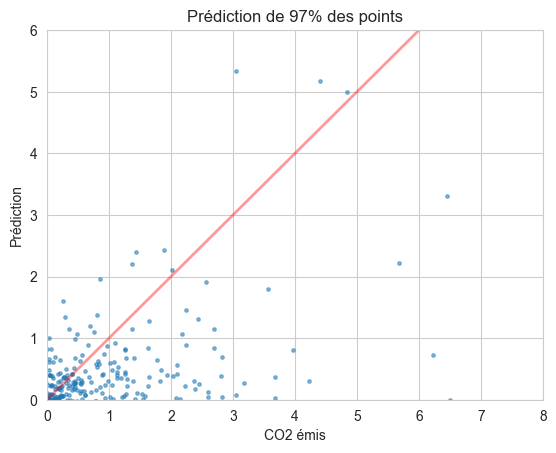

In [491]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 8)
plt.ylim(0, 6)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [492]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue
df_pca = pd.DataFrame(data=df_pca,columns=["comp_1","comp_2","comp_3"])
coef = pd.DataFrame(data=model_pca.coef_,columns=df_pca.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
comp_1,0.260222,0.260222
comp_2,0.174437,0.174437
comp_3,-0.017174,0.017174


Text(0.5, 1.0, 'Coefficients de regression')

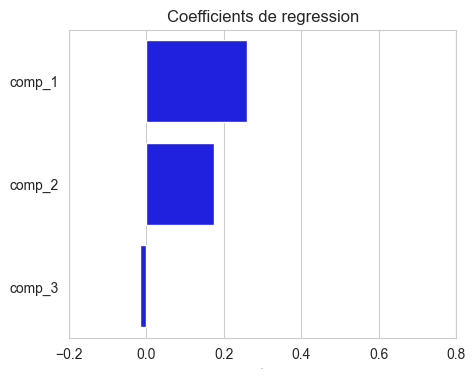

In [493]:
# Graphique des coeff

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.6) Régression sur le log des données
<a class="anchor" id="Section_2.6"></a>

In [494]:
# Transformation des DF en log

df_float[df_float==0]=1
df_float["ENERGYSTARScore"]=df['ENERGYSTARScore']
df_float_log = df_au_log(df_float)
df_energy=df_float_log[["ENERGYSTARScore"]]
df_float_log=df_float_log.drop(columns=["ENERGYSTARScore"])

target[target==0]=1
target_log = df_au_log(target)

C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1134612248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1134612248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1232816784.py:4: RuntimeWarning: invalid value encountered in log
  val = np.log(data_1.values)


In [495]:
df_tot= pd.concat([df_float_log,target_log],axis=1)
df_tot=df_tot.dropna(axis=0,subset="TotalGHGEmissions")
target_log=df_tot[["TotalGHGEmissions"]]
df_float_log = df_tot.drop(columns=["TotalGHGEmissions"])

In [496]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_log = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_log = tps2 - tps1
print("Temps de calcul : ",temps_log,"ms")

Temps de calcul :  0.004994630813598633 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [497]:
print("R2 sur le set d'apprentissage: ",model_log.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_log.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.4199216456264896 
 R2 sur le set de test:  0.4288931533774061


In [498]:
# Création d'un DF des valeurs prédites de X_test
pred = model_log.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.1144515410168245


In [499]:
# Création d'un DF composée de la target la prédiction et les résidus

y_log = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_log = pd.DataFrame(y_log).reset_index()
y_log=y_log.drop(columns=["index"])
pred = pd.concat([y_log[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,3.426865,10.959453,3.340008,0.086857
1,2.745988,10.034954,2.531889,0.214099
2,5.385412,11.986429,4.273668,1.111744
3,2.061787,10.319398,2.396092,-0.334305
4,3.356897,12.005785,4.314886,-0.957989
...,...,...,...,...
994,1.975469,10.071710,2.364669,-0.389200
995,2.272126,10.662422,2.969587,-0.697461
996,3.203965,10.682308,4.030451,-0.826485
997,2.585506,10.627697,3.087757,-0.502251


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

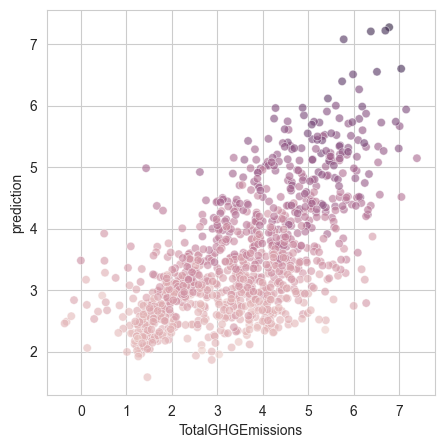

In [500]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

In [501]:
coef = pd.DataFrame(data=model_log.coef_,columns=df_float_log.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,1.095985,1.095985
BulType,0.492486,0.492486
Zip,-0.225263,0.225263
PPT,-0.184200,0.184200
NumberofFloors,-0.179352,0.179352
Voisin,-0.132880,0.132880
years,0.125452,0.125452
Council,0.071850,0.071850
tx_gaz,-0.064071,0.064071
ThirdLargestPropertyUseTypeGFA,0.012243,0.012243


Text(0.5, 1.0, 'Coefficients de regression')

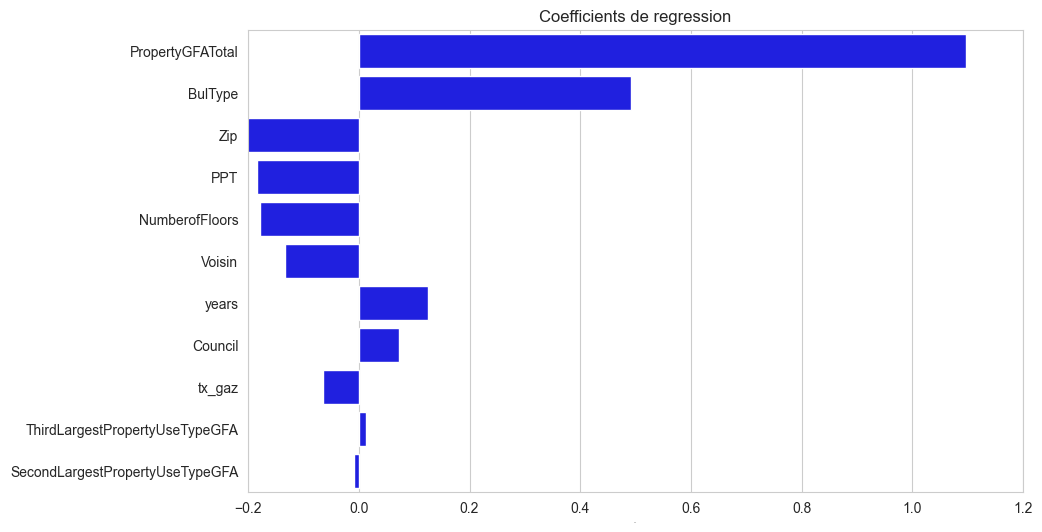

In [502]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.7) Gradient Boosting Regressor sur données en log
<a class="anchor" id="Section_2.7"></a>

In [503]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [504]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
param_grid = { "n_estimators":[50,100,200],
               "max_depth":[2,3,5],
               "alpha":[0.2,0.5,0.9]}

model_gbr = GridSearchCV( GradientBoostingRegressor(random_state=0),
                          param_grid,
                          cv = 10,
                          scoring = score)

model_gbr.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print("Temps de calcul : ",temps_gbr,"ms")

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was pass

Temps de calcul :  117.08403897285461 ms


In [505]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_gbr.cv_results_['mean_test_score'], # score moyen
        model_gbr.cv_results_['std_test_score'],  # écart-type du score
        model_gbr.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.763 (+/-0.056) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.798 (+/-0.064) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 100}
mean_test_score = 0.813 (+/-0.067) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 200}
mean_test_score = 0.792 (+/-0.066) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 50}
mean_test_score = 0.810 (+/-0.072) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 100}
mean_test_score = 0.816 (+/-0.073) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}
mean_test_score = 0.806 (+/-0.074) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 50}
mean_test_score = 0.812 (+/-0.080) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 100}
mean_test_score = 0.811 (+/-0.083) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 200}
mean_test_score = 0.763 (+/-0.056) for {'alpha': 0.5, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.798 (+/-0.064) for {'alpha': 0.5, 'ma

In [506]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_gbr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [507]:
gbr = GradientBoostingRegressor( n_estimators=200,
                                max_depth=3,
                                alpha=0.2)
gbr.fit(X_train,y_train)

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.2, n_estimators=200)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [508]:
print("R2 sur le set d'apprentissage: ",model_gbr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_gbr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8943106514011322 
 R2 sur le set de test:  0.8490844772750323


In [509]:
# Création d'un DF des valeurs prédites de X_test
pred = gbr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5644116471008032


In [510]:
# Création d'un DF composée de la target la prédiction et les résidus

y_bgr = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_bgr = pd.DataFrame(y_bgr).reset_index()
y_bgr = y_bgr.drop(columns=["index"])
pred = pd.concat([y_bgr[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,3.426865,10.959453,3.668849,-0.241984
1,2.745988,10.034954,2.544267,0.201721
2,5.385412,11.986429,5.389943,-0.004531
3,2.061787,10.319398,1.533198,0.528589
4,3.356897,12.005785,3.250364,0.106533
...,...,...,...,...
661,2.530517,9.987507,2.247105,0.283412
662,1.623341,10.015253,1.663653,-0.040313
663,3.127199,11.971489,4.534516,-1.407317
664,3.079154,10.072006,3.099204,-0.020050


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

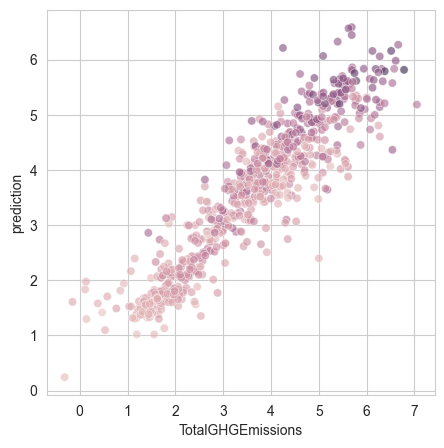

In [511]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

In [512]:
coef =pd.DataFrame(data=gbr.feature_importances_,index=df_float_log.columns,columns=["coeff"])

coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
tx_gaz,0.515650,0.515650
PropertyGFATotal,0.351517,0.351517
PPT,0.046755,0.046755
BulType,0.026025,0.026025
years,0.018395,0.018395
NumberofFloors,0.016974,0.016974
SecondLargestPropertyUseTypeGFA,0.007304,0.007304
Zip,0.007160,0.007160
ThirdLargestPropertyUseTypeGFA,0.005819,0.005819
Voisin,0.003531,0.003531


Text(0.5, 1.0, 'Coefficients de regression')

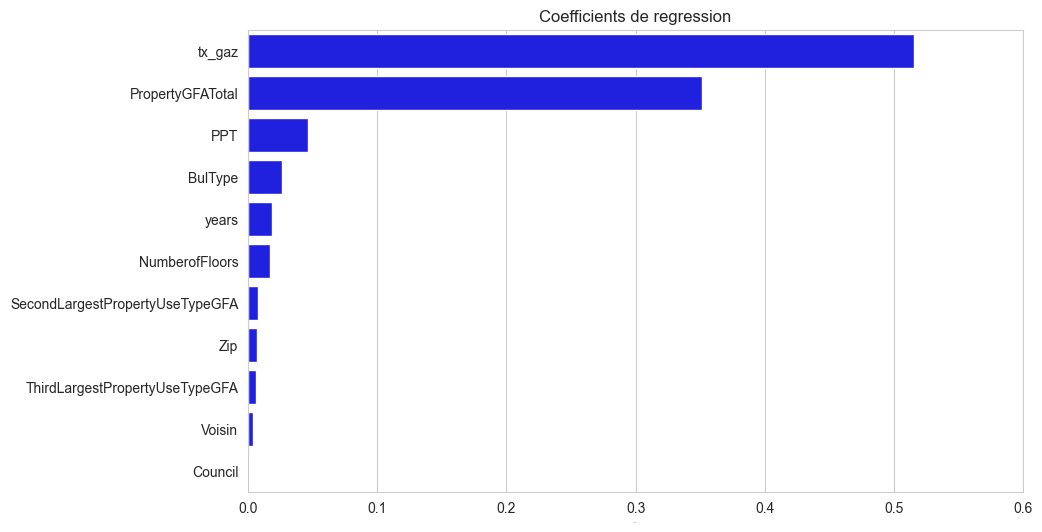

In [513]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 0.6)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.8) XGBoost sur données en log
<a class="anchor" id="Section_2.8"></a>

In [514]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [515]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [2],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb = tps2 - tps1
print("Temps de calcul : ",temps_xgb,"s")

Temps de calcul :  9.397464275360107 s


In [516]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.750 (+/-0.050) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.778 (+/-0.051) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.776 (+/-0.057) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.790 (+/-0.056) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.809 (+/-0.050) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.802 (+/-0.057) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [517]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [518]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.9108419841661584 
 R2 sur le set de test:  0.8471343006015548


In [519]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[12:28:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

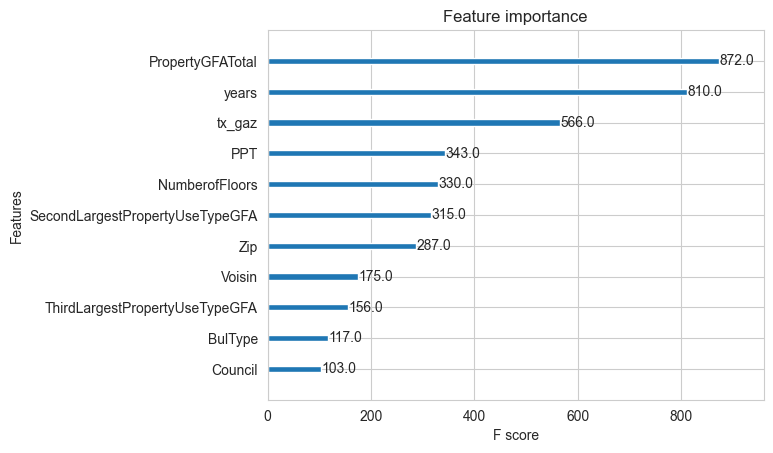

In [520]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [521]:
# Création d'un DF des valeurs prédites de X_test
pred = xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6105190912558325


In [522]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xbg = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_xbg = pd.DataFrame(y_xbg).reset_index()
y_xbg = y_xbg.drop(columns=["index"])
pred = pd.concat([y_xbg[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,3.426865,10.959453,3.883746,-0.456881
1,2.745988,10.034954,2.257331,0.488657
2,5.385412,11.986429,5.704676,-0.319264
3,2.061787,10.319398,1.399140,0.662647
4,3.356897,12.005785,3.383389,-0.026492
...,...,...,...,...
661,2.530517,9.987507,2.163104,0.367413
662,1.623341,10.015253,1.521437,0.101904
663,3.127199,11.971489,4.827525,-1.700326
664,3.079154,10.072006,2.995610,0.083544


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

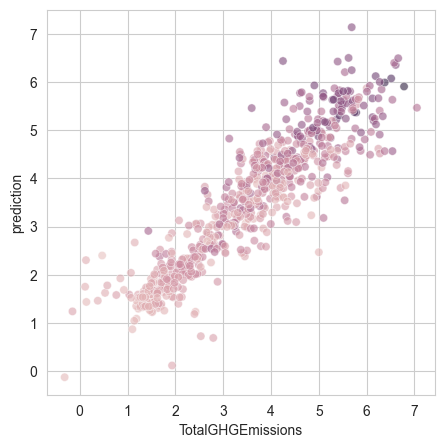

In [523]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## 2.9) Régression XGBoost avec la variable ENERGYSTARScore
<a class="anchor" id="Section_2.9"></a>

In [524]:
# On inclut la variable ENERGYscore ds le modèle
df_float_log = pd.concat([df_float_log,df_energy],axis=1)

In [525]:
# Imputation des données manquantes (ENERGYscore) par les KNN

imputer = KNNImputer(n_neighbors=5)

df_float_log = pd.DataFrame(data=imputer.fit_transform(df_float_log),
                            columns=df_float_log.columns)

In [526]:
# Suppression des dernières données manquantes

df_tot = pd.concat([df_float_log,target_log],axis=1)
df_tot=df_tot.dropna(axis=0,subset="TotalGHGEmissions")
target_log = df_tot[["TotalGHGEmissions"]]
df_float_log = df_tot.drop(columns=["TotalGHGEmissions"])

In [527]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [528]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [1],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb_E = tps2 - tps1
print("Temps de calcul : ",temps_xgb_E,"ms")

Temps de calcul :  19.4066379070282 ms


In [529]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.106 (+/-0.056) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.094 (+/-0.061) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.068 (+/-0.070) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.113 (+/-0.051) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.089 (+/-0.047) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.064 (+/-0.061) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [530]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}


In [531]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[12:28:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.05,
                        'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

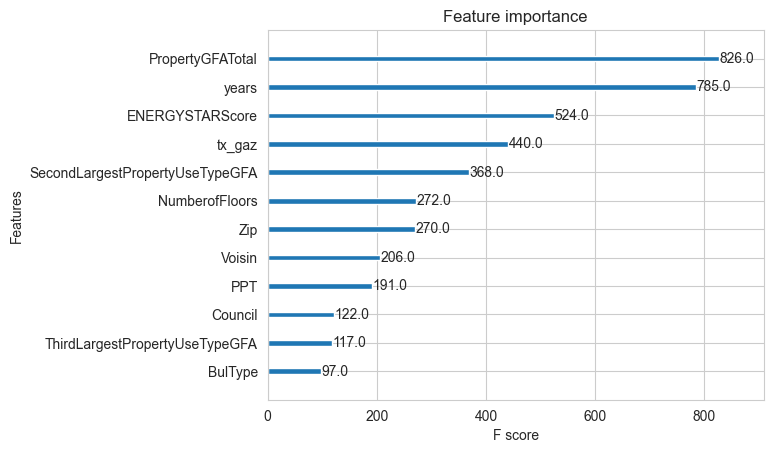

In [532]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [533]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.2132013526861387 
 R2 sur le set de test:  0.12031151325458833


In [534]:
# Création d'un DF des valeurs prédites de X_test
pred = model_xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.3646473278596212


In [535]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xgb_star = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,
                          right_index=True)
y_xgb_star = pd.DataFrame(y_xgb_star).reset_index()
y_xgb_star = y_xgb_star.drop(columns=["index"])
pred = pd.concat([y_xgb_star[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,3.426865,11.396099,3.474586,-0.047720
1,2.745988,10.212662,3.150908,-0.404920
2,5.385412,10.013238,3.083407,2.302005
3,2.061787,11.343145,3.061077,-0.999290
4,3.356897,11.267012,3.135792,0.221105
...,...,...,...,...
661,2.530517,12.335661,3.951787,-1.421270
662,1.623341,10.438284,3.158219,-1.534879
663,3.127199,10.185617,3.152048,-0.024849
664,3.079154,11.381632,3.233073,-0.153919


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

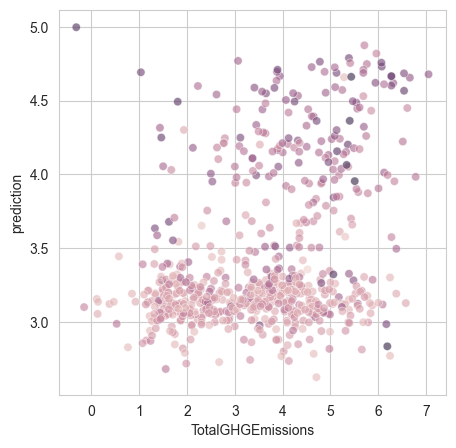

In [536]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## Conclusion partie 2
<a class="anchor" id="Conclusion"></a>

# 📄 References<a class="anchor" id="Références"></a>
- [Data Seattle](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
- [Librairie Pandas](https://pandas.pydata.org/docs/user_guide/index.html#)
- [Librairie scikit-learn](https://scikit-learn.org/stable/user_guide.html)
- [Librairie XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)